In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

In [2]:
%run utilities.py

# Load and scale the data

In [3]:
np.random.seed(3)

In [4]:
x, y = load_matlab_data('hwkdataNEW.mat')

In [5]:
xtr, ytr, xts, yts, xv, yv = train_test_val_split(x, y)

In [6]:
column_names = [
    'Age', 'Weight', 'Height', 'Adiposity Index',
    'Neck Circumference', 'Chest Circumference',
    'Ab Circumference', 'Hip Circumference',
    'Thigh Circumference', 'Knee Circumference',
    'Ankle Circumference', 'Extended Bicep Circumference',
    'Forearm  Circumference', 'Wrist Circumference'
]

In [7]:
scaler = StandardScaler()
scaler.fit(xtr)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Transform the data into PCA space

In [8]:
xtr_scaled = scaler.transform(xtr)
pca = PCA()
xtr_scaled_pca = pca.fit_transform(xtr_scaled)

In [9]:
pca_pipeline = Pipeline(
    memory=None,
    steps=[
        ('scale', StandardScaler()),
        ('pca', PCA()),
    ]
)
pca_pipeline.fit(xtr)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

# Analyze the PCA

## How much variance does each loading capture?

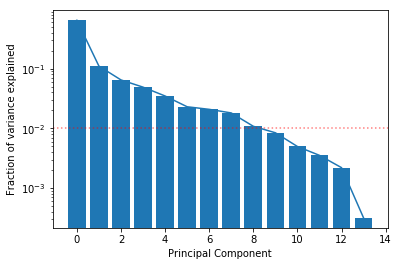

In [10]:
evr = pca_pipeline.named_steps['pca'].explained_variance_ratio_
plt.plot(pca_pipeline.named_steps['pca'].explained_variance_ratio_)
plt.bar(range(len(evr)), evr)
plt.axhline(y=0.01, linestyle=':', color='r', alpha=0.5)
plt.xlabel("Principal Component")
plt.ylabel("Fraction of variance explained")
plt.yscale('log')
plt.savefig('images/fractional_variance_explained.png', dpi=300)
plt.show()

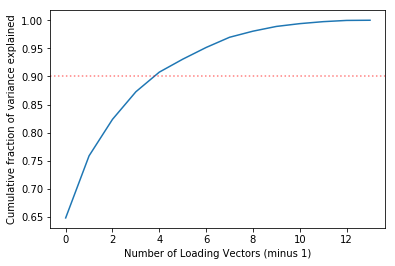

In [11]:
cum_evr = np.cumsum(pca_pipeline.named_steps['pca'].explained_variance_ratio_)
plt.plot(cum_evr)
plt.xlabel("Number of Loading Vectors (minus 1)")
plt.ylabel("Cumulative fraction of variance explained")
plt.axhline(y=0.9, linestyle=':', color='r', alpha=0.5)
plt.savefig('images/cumulative_variance.png', dpi=300)
plt.show(block=True)

In [12]:
np.where(cum_evr < 0.9)

(array([0, 1, 2, 3]),)

In [13]:
cum_evr[4]

0.9077686974842645

## How correlated is each PCA to Body Fat Percentage?

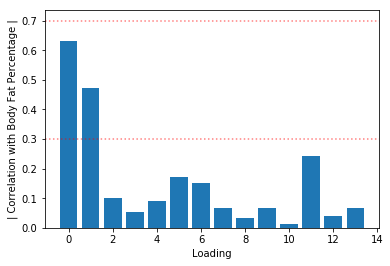

In [14]:
corr_vec = np.corrcoef(x=xtr_scaled_pca, y=ytr, rowvar=False)[-1, :-1]
plt.bar(x=range(len(corr_vec)), height=np.abs(corr_vec))
plt.xlabel('Loading')
plt.ylabel('| Correlation with Body Fat Percentage |')
plt.axhline(y=0.7, linestyle=':', color='r', alpha=0.5)
plt.axhline(y=0.3, linestyle=':', color='r', alpha=0.5)
plt.savefig('images/pca_correlation.png', dpi=300)
plt.show(block=True)

In [15]:
components_sorted_by_correlation = np.argsort(np.abs(corr_vec))[::-1]

## Are the correlations between the various loadings linear?

In [16]:
def plot_loading_scatter(loading_num):
    sns.scatterplot(x=xtr_scaled_pca[:,loading_num], y=ytr.ravel())
    plt.xlabel(f'Loading {loading_num}')
    plt.ylabel('Body Fat Percentage')
    plt.savefig(f'images/pca_{loading_num}_scatter.png', dpi=300)
    plt.show(block=True)

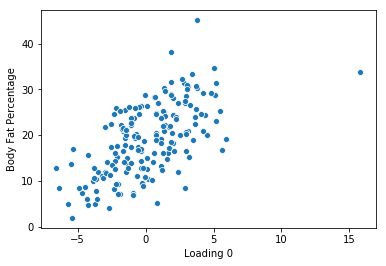

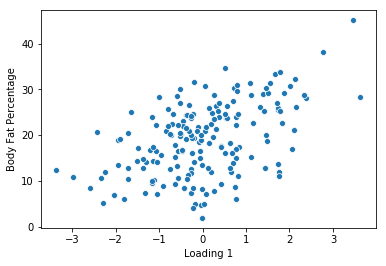

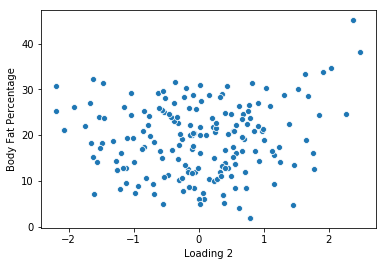

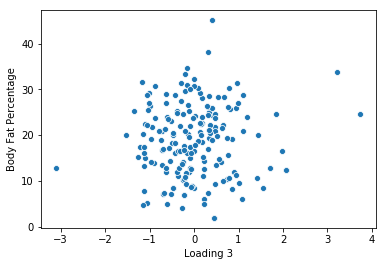

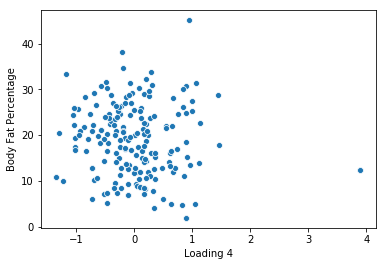

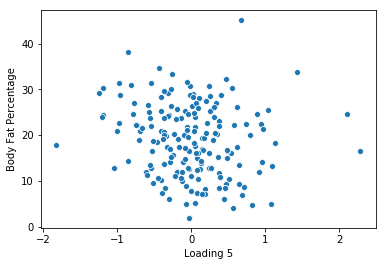

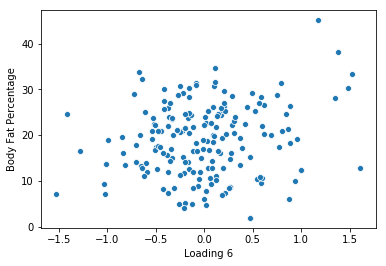

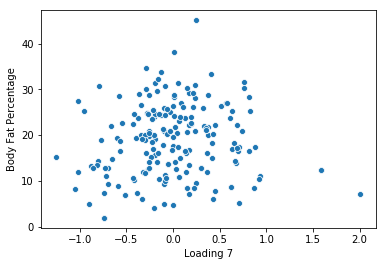

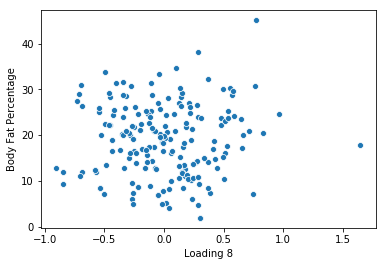

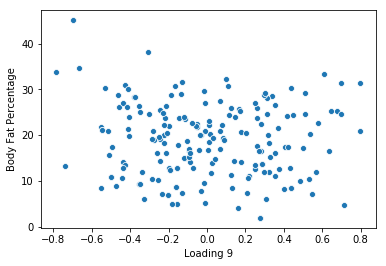

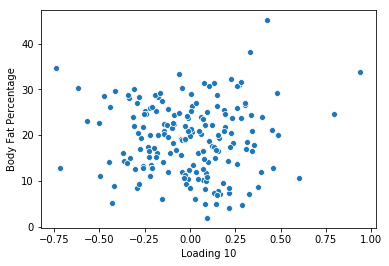

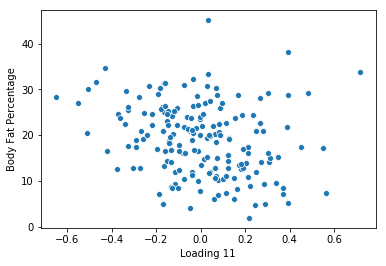

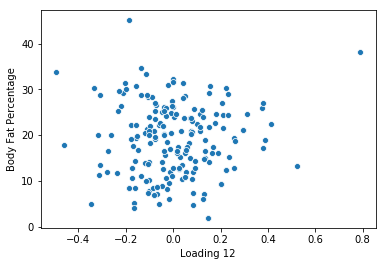

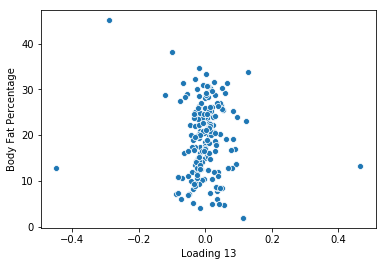

In [17]:
for _ in range(14):
    plot_loading_scatter(_)

This shows that the first loading is correlated with body fat, 
the second loading less so, and there is no visual correlation 
after that. No apparent non-linear relationships were noted.

## What are the first few PCA loadings comprised of?

In [18]:
pca_data = pca_pipeline.named_steps['pca']

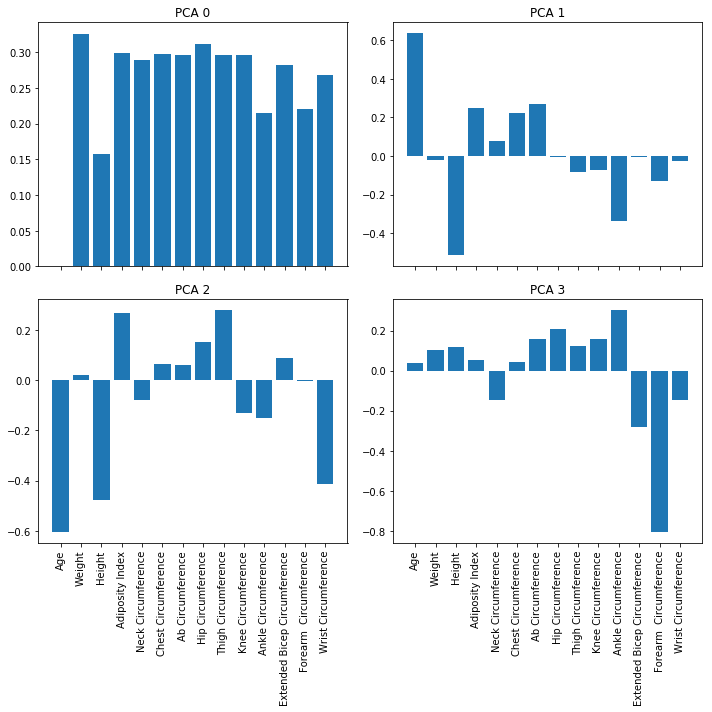

In [19]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize=(10,10))
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)
ax1.bar(x=column_names, height=pca_data.components_[0])
ax1.set_title('PCA 0')
ax2.bar(x=column_names, height=pca_data.components_[1])
ax2.set_title('PCA 1')
ax3.bar(x=column_names, height=pca_data.components_[2])
plt.xticks(rotation=90)
ax3.set_title('PCA 2')
ax4.bar(x=column_names, height=pca_data.components_[3])
plt.xticks(rotation=90)
ax4.set_title('PCA 3')
#plt.suptitle("The First 4 Principal Component Loadings")
plt.tight_layout()
plt.savefig('images/first_four_pca.png', dpi=300)
plt.show()

## Conclusions

The data are approximately 2-3 dimensional based on two loadings 
that explain greater than 1% of the variance each. A total of 90% 
of the variance is explained by the first 5 loadings. The first 
loading consists of all of the measured input variables except age. 

# PCA Regression

## PCR capturing 90% of the variation in the input space

In [20]:
pcr_90_percent = LinearRegression()
pcr_90_percent.fit(xtr_scaled_pca[:,:5], ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

`pca_pipeline.transform(x)` applies the same scaling and PCA 
transformation determined from the training set to `x` (in 
this case, the test data).

In [21]:
xts_scaled_pca = pca_pipeline.transform(xts)

In [22]:
pcr_90_percent_performance = rmse(
    pcr_90_percent.predict(xts_scaled_pca[:,:5]), yts)
print(pcr_90_percent_performance)

5.025354123263135


## PCR consisting of all loadings with >1% of variance

To pick the correct PC's based on fraction of variance they 
capture, we compare their eigenvalues (normalized to the sum 
of all of the eigenvalues). This is equivalent to the fraction 
of variance they explain.

In [23]:
pcr_gt10_percent = LinearRegression()
pcr_gt10_percent.fit(xtr_scaled_pca[:,:9], ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [24]:
pcr_gt10_percent_performance = rmse(
    pcr_gt10_percent.predict(xts_scaled_pca[:,:9]), yts)
print(pcr_gt10_percent_performance)

4.500349403760107


## PC's most useful for predicting percent body fat

This was equivalent to including PC's that are correlated with body 
fat (>0.3), and consisted of only the first 2 loadings. To explore 
this further, I will include the next most correlated PC (index 11).

In [25]:
pcr_correlated = LinearRegression()
pcr_correlated.fit(xtr_scaled_pca[:, [0, 1, 11]], ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
pcr_correlated_performance = rmse(
    pcr_correlated.predict(xts_scaled_pca[:, [0, 1, 11]]), yts)
print(pcr_correlated_performance)

4.235353993977762


In [27]:
pcr_correlated2 = LinearRegression()
pcr_correlated2.fit(xtr_scaled_pca[:, [0, 1]], ytr)
pcr_correlated2_performance = rmse(
    pcr_correlated2.predict(xts_scaled_pca[:, [0, 1]]), yts)
print(pcr_correlated2_performance)

4.916291312494971


## Watch how performance on the test set improves 
## as components are added in order of correlation

In [28]:
corr_pc_perf = []
for _ in range(1,corr_vec.shape[0]):
    pcs = components_sorted_by_correlation[:_]
    print(f'Using columns {pcs}')
    lr = LinearRegression()
    lr.fit(xtr_scaled_pca[:,pcs], ytr)
    e = rmse(lr.predict(pca.transform(scaler.transform(xts))[:,pcs]), yts)
    corr_pc_perf.append(e)
    print(f'Testing error for the {_} most correlated PC(s) is {e}')

Using columns [0]
Testing error for the 1 most correlated PC(s) is 5.320244744919409
Using columns [0 1]
Testing error for the 2 most correlated PC(s) is 4.916291312494971
Using columns [ 0  1 11]
Testing error for the 3 most correlated PC(s) is 4.235353993977762
Using columns [ 0  1 11  5]
Testing error for the 4 most correlated PC(s) is 3.693315358101633
Using columns [ 0  1 11  5  6]
Testing error for the 5 most correlated PC(s) is 3.75431396319686
Using columns [ 0  1 11  5  6  2]
Testing error for the 6 most correlated PC(s) is 3.7348589068984572
Using columns [ 0  1 11  5  6  2  4]
Testing error for the 7 most correlated PC(s) is 4.110847389389282
Using columns [ 0  1 11  5  6  2  4  7]
Testing error for the 8 most correlated PC(s) is 4.020216367839246
Using columns [ 0  1 11  5  6  2  4  7  9]
Testing error for the 9 most correlated PC(s) is 3.8910682314369107
Using columns [ 0  1 11  5  6  2  4  7  9 13]
Testing error for the 10 most correlated PC(s) is 3.8974532373213906
Using

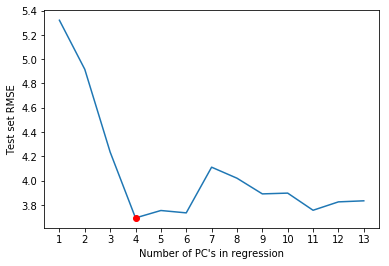

In [29]:
plt.plot(corr_pc_perf)
plt.plot(3, np.min(corr_pc_perf), 'ro')
plt.ylabel('Test set RMSE')
plt.xlabel('Number of PC\'s in regression')
plt.xticks(np.arange(len(corr_pc_perf)), range(1,len(corr_pc_perf)+1))
plt.savefig('images/selective_pcr_performance.png', dpi=300)
plt.show()

It appears that columns 0, 1, 11, and 5 make for the best regression

In [30]:
pcr_correlated3 = LinearRegression()
pcr_correlated3.fit(xtr_scaled_pca[:, [0, 1, 5, 11]], ytr)
pcr_correlated3_performance = rmse(
    pcr_correlated3.predict(xts_scaled_pca[:, [0, 1, 5, 11]]), yts)
print(pcr_correlated3_performance)

3.693315358101633


Check the condition number of this input matrix ($\lambda_0 / \lambda_{11}$)

In [31]:
evr = pca_pipeline.named_steps['pca'].explained_variance_ratio_
evr[0] / evr[11]

183.925651898804

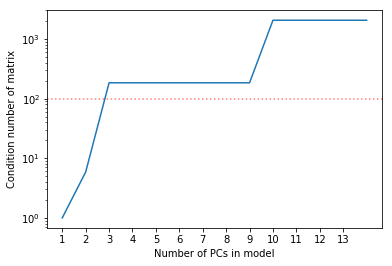

In [32]:
plt.plot([evr[0] / np.min(evr[components_sorted_by_correlation[:i]])\
          for i in range(1,components_sorted_by_correlation.shape[0]+1)])
plt.xlabel("Number of PCs in model")
plt.ylabel("Condition number of matrix")
plt.xticks(np.arange(len(corr_pc_perf)), range(1,len(corr_pc_perf)+1))
plt.axhline(y=100, color='r', linestyle=':', alpha=0.5)
plt.yscale('log')
plt.savefig('images/condition_number_corr_ordered.png', dpi=300)
plt.show()

## All the PCA's

In [33]:
pcr_all = LinearRegression()
pcr_all.fit(xtr_scaled_pca, ytr)
pcr_all_performance = rmse(pcr_all.predict(xts_scaled_pca), yts)
print(pcr_all_performance)

3.83265877750213


# Comparison of PCR performance

In [34]:
models = {
    'Model': [
        'PCR Capturing 90% of Variance',
        'PCR of loadings with >1% of Variance',
        'PCR of correlated loadings (>0.3)',
        'PCR of correlated loadings (>0.2)',
        'Best PCR sorted by correlation',
        'PCR of all loadings',
    ],
    'RMSE': [
        pcr_90_percent_performance,
        pcr_gt10_percent_performance,
        pcr_correlated_performance,
        pcr_correlated2_performance,
        pcr_correlated3_performance,
        pcr_all_performance
    ]
}

In [35]:
test_results = pd.DataFrame(models)
test_results

,Model,RMSE
0,PCR Capturing 90% of Variance,5.025354
1,PCR of loadings with >1% of Variance,4.500349
2,PCR of correlated loadings (>0.3),4.235354
3,PCR of correlated loadings (>0.2),4.916291
4,Best PCR sorted by correlation,3.693315
5,PCR of all loadings,3.832659


In [36]:
print(test_results.to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                Model &      RMSE \\
\midrule
        PCR Capturing 90\% of Variance &  5.025354 \\
 PCR of loadings with >1\% of Variance &  4.500349 \\
    PCR of correlated loadings (>0.3) &  4.235354 \\
    PCR of correlated loadings (>0.2) &  4.916291 \\
       Best PCR sorted by correlation &  3.693315 \\
                  PCR of all loadings &  3.832659 \\
\bottomrule
\end{tabular}



# Calculate the error on the validation set

In [37]:
val_scaled_pca = pca_pipeline.transform(xv)
pcr_correlated3_val_performance = rmse(
    pcr_correlated3.predict(val_scaled_pca[:, [0, 1, 5, 11]]), yv)
print(pcr_correlated3_val_performance)

4.721443598706105


In [38]:
naive_linear_model = LinearRegression()
naive_linear_model.fit(scaler.transform(xtr), ytr)
naive_linear_model_performance = rmse(
    naive_linear_model.predict(scaler.transform(xv)), yv)
print(naive_linear_model_performance)

4.190271270372612


# Compare to the "best" conventional linear regression

In [39]:
best_linear = LinearRegression()
best_xtr = np.hstack([xtr[:,[6, 2, 13]], 1 / xtr[:, 1].reshape((-1, 1))])
linear_scaler = StandardScaler()
best_xtr_scaled = linear_scaler.fit_transform(best_xtr)
best_linear.fit(best_xtr_scaled, ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [40]:
best_xts_scaled = linear_scaler.transform(
    np.hstack([xts[:,[6, 2, 13]], 1 / xts[:, 1].reshape((-1, 1))]))
yts_pred = best_linear.predict(best_xts_scaled)

In [41]:
rmse(yts, yts_pred)

3.854667278350122

In [42]:
best_xv_scaled = linear_scaler.transform(
    np.hstack([xv[:,[6, 2, 13]], 1 / xv[:, 1].reshape((-1, 1))]))
yv_pred = best_linear.predict(best_xv_scaled)

In [43]:
rmse(yv, yv_pred)

4.78603072296239

In [44]:
np.linalg.cond(best_xts_scaled)

7.251468787177976